# Arabic Sign Language Recognition

Dataset used: https://hamzah-luqman.github.io/KArSL/

In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
!pip install mediapipe
import mediapipe as mp
from PIL import Image
import tensorflow as tf
from random import randint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 39.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompat

2024-06-05 17:37:36.871813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 17:37:36.872039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 17:37:37.043351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
n_frames = 60 # N Frames Per Prediction
n_keypoints = 225 # N Keypoints captured by mediapipe
tf.random.set_seed(15) 

In [3]:
class DataLoader:
    mp_holistic = mp.solutions.holistic
    mp_drawing = mp.solutions.drawing_utils
    X, Y = [], []

    # Method for extracting the keypoints in images
    def extract_keypoints(results):
        pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
        
        nose = pose[:3]
        lh_wrist = lh[:3]
        rh_wrist = rh[:3]
        
        pose_adjusted = DataLoader.adjust_landmarks(pose, nose)
        lh_adjusted = DataLoader.adjust_landmarks(lh, lh_wrist)
        rh_adjusted = DataLoader.adjust_landmarks(rh, rh_wrist)
        
        return np.concatenate((pose_adjusted, lh_adjusted, rh_adjusted))


    # Drawing the key points on images to see the results
    def draw_styled_landmarks(image, results):
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 ) 
        # Draw left hand connections
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 ) 
        # Draw right hand connections  
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 ) 

    def adjust_landmarks(arr, center):
        # Reshape the array to have shape (n, 3)
        arr_reshaped = arr.reshape(-1, 3)

        # Repeat the center array to have shape (n, 3)
        center_repeated = np.tile(center, (len(arr_reshaped), 1))

        # Subtract the center array from the arr array
        arr_adjusted = arr_reshaped - center_repeated

        # Reshape arr_adjusted back to shape (n*3,)
        arr_adjusted = arr_adjusted.reshape(-1)
        
        return arr_adjusted
    
    def load_data(frames_dir):
        # List to store results
        results_list = []

        # Loop through frames in the directory
        for filename in sorted(os.listdir(frames_dir)):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust file extensions as needed
                # Read the image
                image_path = os.path.join(frames_dir, filename)
                image = np.array(Image.open(image_path).convert('RGB'))

                # Convert image to RGB format (if it's not already in RGB)
                if image.shape[-1] == 1:  # Grayscale image
                    image = np.repeat(image, 3, axis=-1)  # Convert to RGB by repeating the grayscale channel

                # Detect landmarks using MediaPipe Holistic
                with DataLoader.mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                    results = holistic.process(image)
                    results_extracted = DataLoader.extract_keypoints(results)

                # Append results to the results list
                results_list.append(results_extracted)
        
        if len(results_list) > n_frames: return

        # Convert results list to NumPy array
        while len(results_list) < n_frames:
            results_list.append(np.zeros((n_keypoints)))

        results_array = np.array(results_list)

        DataLoader.X.append(results_array)
        DataLoader.Y.append(frames_dir)

## Loading Data Through Training Files

Expand only if reloading, otherwise load data from NPY files

In [ ]:
main_folder = "/kaggle/input/data-010/01/01/test"
os.listdir(main_folder)

In [ ]:
for folder in os.listdir(main_folder)[1:3]:
    if os.path.isdir(os.path.join(main_folder, folder)):
        subfolder = os.path.join(main_folder, folder)

        for sign in os.listdir(subfolder):
            path = os.path.join(subfolder, sign)
            
            for trial in os.listdir(path):
                trial_path = os.path.join(path, trial)
                DataLoader.load_data(trial_path)
            
                if len(DataLoader.Y) % 100 == 0: print(len(DataLoader.Y)) 
len(DataLoader.Y)

In [ ]:
new_Y = []
for i in range(len(DataLoader.Y)):
    label = DataLoader.Y[i][56:60]
    if label not in labels:
        labels[label] = ctr
        itol[ctr] = label
        ctr += 1
        
    new_Y.append(labels[label])
print(labels)

X, Y = np.array(DataLoader.X), to_categorical(np.array(new_Y)).astype(int)
print(X.shape, Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

## Labels ordered by index as by model predictions

In [4]:
# Maps local labels to Arabic Translations
arabic_labels = {
    0: 'يدعم',  # supports
    1: 'يدخن',  # smokes
    2: 'يكسر',  # breaks
    3: 'يحب',   # loves
    4: 'يشوي',  # grills
    5: 'يحصد',  # harvests
    6: 'يحرث',  # plows
    7: 'يكره',  # hates
    8: 'يستحم', # bathes
    9: 'يسقي',  # irrigates
    10: 'يساعد', # helps
    11: 'يبني',  # builds
    12: 'يمشي',  # walks
    13: 'يتنامى', # grows
    14: 'يختار', # chooses
    15: 'يفكر',  # thinks
    16: 'ينادي', # calls
    17: 'يصبغ',  # dyes
    18: 'يقف',   # stands
    19: 'ث',
    20: '100',
    21: 'غ',
    22: 'ظ',
    23: 'ر',
    24: '500',
    25: '0',
    26: '6',
    27: 'ال',
    28: '1000000',
    29: 'ى',
    30: 'ح',
    31: 'د',
    32: '10000000',
    33: 'ش',
    34: 'س',
    35: 'إ',
    36: '70',
    37: '10',
    38: '90',
    39: '4',
    40: 'ؤ',
    41: 'ق',
    42: 'ي',
    43: '40',
    44: '60',
    45: '8',
    46: 'خ',
    47: 'ص',
    48: 'آ',
    49: 'ب',
    50: '200',
    51: 'ج',
    52: '400',
    53: 'م',
    54: 'ه',
    55: 'ئـ',
    56: '9',
    57: '300',
    58: '700',
    59: '3',
    60: 'ط',
    61: '80',
    62: 'ك',
    63: '50',
    64: 'ء',
    65: 'ز',
    66: 'ذ',
    67: 'أ',
    68: '30',
    69: 'لا',
    70: 'ت',
    71: '1000',
    72: '7',
    73: 'ل',
    74: 'ئ',
    75: 'أ',
    76: 'ف',
    77: 'و',
    78: '600',
    79: 'ا',
    80: '2',
    81: 'ع',
    82: '20',
    83: '1',
    84: 'ة',
    85: 'لا',
    86: 'ض',
    87: 'ن',
    88: '800'
}

# Maps folder numbers (KArSL Indices to local labels)
actions = {
    '0184': 0,
    '0183': 1,
    '0172': 2,
    '0174': 3,
    '0176': 4,
    '0179': 5,
    '0177': 6,
    '0175': 7,
    '0190': 8,
    '0180': 9,
    '0182': 10,
    '0171': 11,
    '0173': 12,
    '0187': 13,
    '0185': 14,
    '0181': 15,
    '0186': 16,
    '0188': 17,
    '0189': 18,
    '0035': 19,
    '0020': 20,
    '0050': 21,
    '0048': 22,
    '0041': 23,
    '0024': 24,
    '0001': 25,
    '0007': 26,
    '0070': 27,
    '0030': 28,
    '0068': 29,
    '0037': 30,
    '0039': 31,
    '0031': 32,
    '0044': 33,
    '0043': 34,
    '0066': 35,
    '0011': 37,
    '0019': 38,
    '0005': 39,
    '0062': 40,
    '0052': 41,
    '0059': 42,
    '0014': 43,
    '0016': 44,
    '0009': 45,
    '0038': 46,
    '0045': 47,
    '0067': 48,
    '0033': 49,
    '0021': 50,
    '0036': 51,
    '0023': 52,
    '0055': 53,
    '0057': 54,
    '0064': 55,
    '0010': 56,
    '0022': 57,
    '0026': 58,
    '0004': 59,
    '0047': 60,
    '0018': 61,
    '0053': 62,
    '0015': 63,
    '0065': 64,
    '0042': 65,
    '0040': 66,
    '0013': 68,
    '0017': 69,
    '0034': 70,
    '0029': 71,
    '0008': 72,
    '0054': 73,
    '0063': 74,
    '0061': 75,
    '0051': 76,
    '0058': 77,
    '0025': 78,
    '0032': 79,
    '0003': 80,
    '0049': 81,
    '0012': 82,
    '0002': 83,
    '0060': 84,
    '0069': 85,
    '0046': 86,
    '0056': 87,
    '0027': 88,
}

# Load data from NPY files

In [6]:
# IF DATA IS ALREADY LOADED: START HERE
X_train = np.load("/kaggle/input/karsl-89-labels/X_train.npy")
Y_train = np.load("/kaggle/input/karsl-89-labels/Y_train.npy")
X_test = np.load("/kaggle/input/karsl-89-labels/X_test.npy")
Y_test = np.load("/kaggle/input/karsl-89-labels/Y_test.npy")
X_unknown = np.load("/kaggle/input/karsl-89-labels/X_unknown.npy")
Y_unknown = np.load("/kaggle/input/karsl-89-labels/Y_unknown.npy")

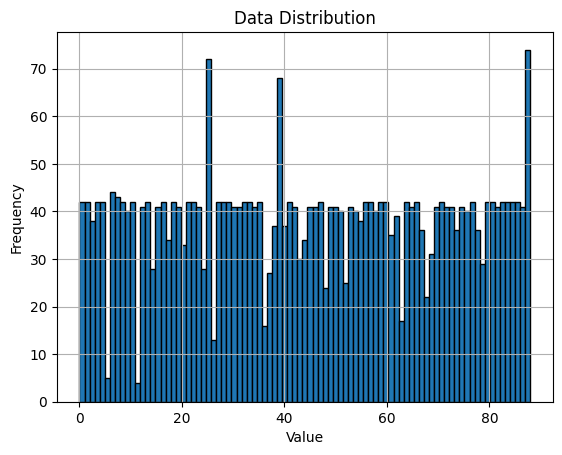

In [7]:
plt.hist(np.argmax(Y_train, axis=1).tolist() + np.argmax(Y_test, axis=1).tolist(), bins=89, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Data Distribution')
plt.grid(True)
plt.show()

## Model Definition & Training

In [65]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(89, activation='softmax')
])
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [66]:
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - categorical_accuracy: 0.0567 - loss: 4.2870 - val_categorical_accuracy: 0.2116 - val_loss: 3.1637
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.2511 - loss: 2.8565 - val_categorical_accuracy: 0.3826 - val_loss: 2.2299
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.3584 - loss: 2.1804 - val_categorical_accuracy: 0.4609 - val_loss: 1.7416
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.4759 - loss: 1.7165 - val_categorical_accuracy: 0.5536 - val_loss: 1.4864
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.5582 - loss: 1.4229 - val_categorical_accuracy: 0.5797 - val_loss: 1.2765
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.6276 - loss: 1.1780 - val_categorical_accuracy: 0.6580 - val_loss: 1.0611
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.6813 - loss: 0.98

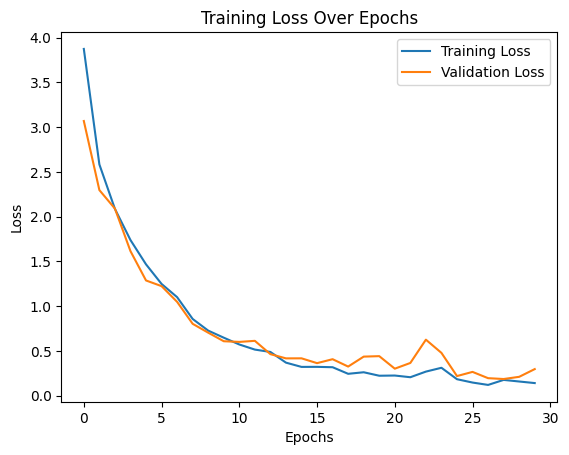

In [34]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 60, 128)        │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 89)             │        11,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,869 (3.15 MB)

 Trainable params: 275,289 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 550,580 (2.10 MB)

## Metrics for test data

In [36]:
yhat = model.predict(X_test)
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(ytrue, yhat)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


0.8927536231884058

In [37]:
conf_matrix = confusion_matrix(yhat, ytrue)

print('Confusion Matrix:')
for row in conf_matrix:
    for value in row:
        print(value, end=' ')
    print()

Confusion Matrix:
8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

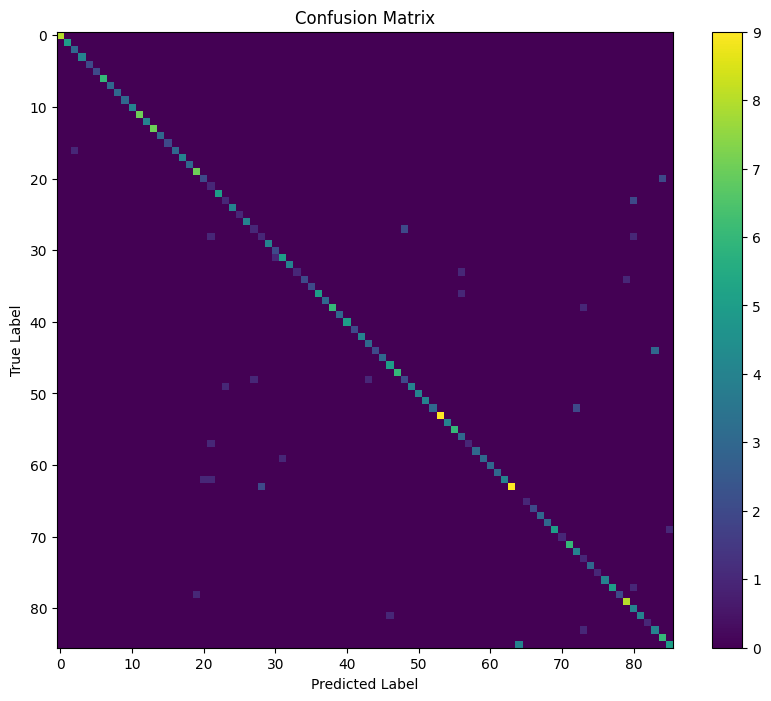

In [38]:
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [39]:
y_pred, y_true = yhat, ytrue
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
unweighted_precision, unweighted_recall, unweighted_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

print("Weighted Precision:", precision * 100)
print("Weighted Recall:", recall * 100)
print("Weighted F1 Score:", f1_score * 100)
print("Unweighted Precision:", unweighted_precision * 100)
print("Unweighted Recall:", unweighted_recall * 100)
print("Unweighted F1 Score:", unweighted_f1_score * 100)

Weighted Precision: 90.9004329004329
Weighted Recall: 89.27536231884058
Weighted F1 Score: 88.73198715653959
Unweighted Precision: 88.91187623745762
Unweighted Recall: 90.23486526393502
Unweighted F1 Score: 88.07011577873412


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Inference & Metrics on Unseen data

In [40]:
probs = model.predict(X_unknown)
yhat = np.argmax(probs, axis=1).tolist()
ytrue = np.argmax(Y_unknown, axis=1).tolist()
for i in range(len(Y_unknown)):
    print(f"""True: {ytrue[i]} -> {arabic_labels[ytrue[i]]}, Predicted: {yhat[i]} -> {arabic_labels[yhat[i]]}, Confidence {probs[i][[yhat[i]]] * 100}""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
True: 19 -> ث, Predicted: 19 -> ث, Confidence [91.00371]
True: 19 -> ث, Predicted: 19 -> ث, Confidence [95.40518]
True: 19 -> ث, Predicted: 19 -> ث, Confidence [66.475]
True: 19 -> ث, Predicted: 19 -> ث, Confidence [83.915665]
True: 19 -> ث, Predicted: 19 -> ث, Confidence [56.521328]
True: 19 -> ث, Predicted: 19 -> ث, Confidence [98.75416]
True: 19 -> ث, Predicted: 19 -> ث, Confidence [97.87047]
True: 19 -> ث, Predicted: 19 -> ث, Confidence [97.98623]
True: 20 -> 100, Predicted: 20 -> 100, Confidence [99.99676]
True: 20 -> 100, Predicted: 20 -> 100, Confidence [99.903145]
True: 20 -> 100, Predicted: 20 -> 100, Confidence [99.9884]
True: 20 -> 100, Predicted: 20 -> 100, Confidence [87.18109]
True: 20 -> 100, Predicted: 20 -> 100, Confidence [99.99871]
True: 20 -> 100, Predicted: 20 -> 100, Confidence [99.98801]
True: 20 -> 100, Predicted: 20 -> 100, Confidence [99.9882]
True: 20 -> 100, Predicted: 20 -> 100, Confidence [99.99142]
True: 21 -> غ, Pre

In [41]:
probs = model.predict(X_unknown)
yhat = np.argmax(probs, axis=1).tolist()
ytrue = np.argmax(Y_unknown, axis=1).tolist()
accuracy_score(yhat, ytrue)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.88

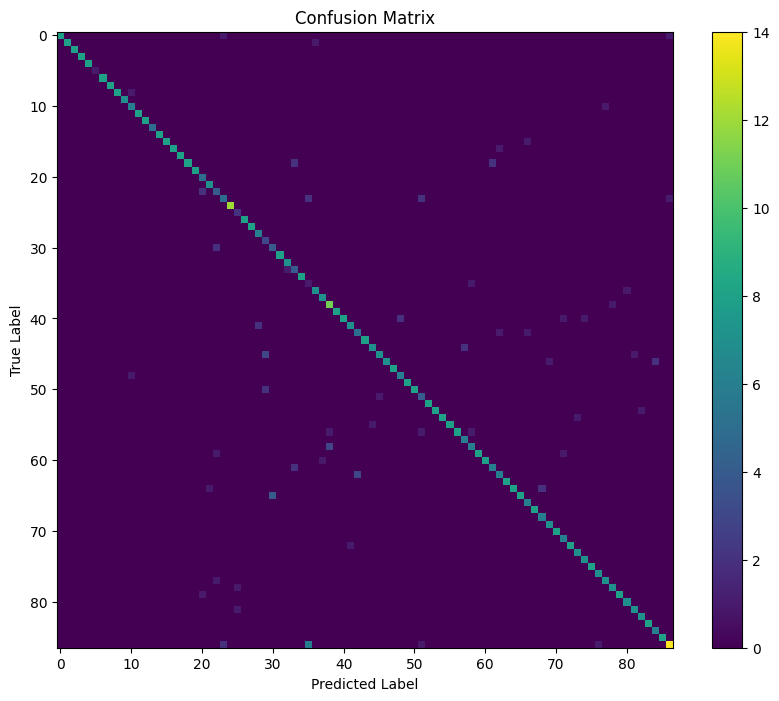

In [42]:
conf_matrix = confusion_matrix(yhat, ytrue)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Inference on Real-time videos

In [43]:
directory = "/kaggle/input/data-010/01/01/test/0171-0190/0176/03_01_0176_(13_09_17_14_05_09)_c"
image_files1 = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]
image_files1.sort()

In [ ]:
images1 = []
for filename in image_files1:
    images1.append(imageio.imread(os.path.join(directory, filename)))
imageio.mimsave('movie1.gif', images1)

### The sign for 'grill' or in arabic 'يشوي'

![Movie1](./movie1.gif)

In [ ]:
DataLoader.load_data(directory)

In [46]:
x = np.expand_dims(DataLoader.X[-1], axis=0)
prediction = model.predict(x)
predicted_label = arabic_labels[np.argmax(prediction, axis=1).item()]
print(f"""Predicted: {predicted_label}
            True Label: {"يشوي"}""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: يشوي
            True Label: يشوي


In [47]:
directory2 = "/kaggle/input/data-010/01/01/test/0171-0190/0184/03_01_0184_(13_09_17_14_26_09)_c"

In [ ]:
image_files2 = [f for f in os.listdir(directory2) if f.endswith('.jpg') or f.endswith('.png')]
image_files2.sort()
images2 = []
for filename in image_files2:
    images2.append(imageio.imread(os.path.join(directory2, filename)))
imageio.mimsave('movie2.gif', images2)

### The sign for 'Support' or in arabic 'يدعم'

![Movie2](./movie2.gif)

In [ ]:
DataLoader.load_data(directory2)

In [50]:
x = np.expand_dims(DataLoader.X[-1], axis=0)
prediction = model.predict(x)
predicted_label = arabic_labels[np.argmax(prediction, axis=1).item()]
print(f"""Predicted: {predicted_label}
            True Label: {"يدعم"}""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: يدعم
            True Label: يدعم


In [71]:
directory3 = "/kaggle/input/188-mariam"

In [ ]:
image_files3 = [f for f in os.listdir(directory3) if f.endswith('.jpg') or f.endswith('.png')]
image_files3.sort()
images3 = []
for filename in image_files3:
    images3.append(imageio.imread(os.path.join(directory3, filename)))
imageio.mimsave('movie3.gif', images3)

In [ ]:
DataLoader.load_data(directory3)

![Movie3](./movie3.gif)

In [75]:
x = np.expand_dims(DataLoader.X[-1], axis=0)
prediction = model.predict(x)
predicted_label = arabic_labels[np.argmax(prediction, axis=1).item()]
print(f"""Predicted: {predicted_label}
            True Label: {"يصبغ"}""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: يصبغ
            True Label: يصبغ
